Source: This example comes from the torch adaptation of Charles Ollion [/github/charlesollion].

In [18]:

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

Data Acquisition

In [19]:
df = pd.read_csv("preprocessed_dataset.csv")
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

Data loading and preprocessing. Data is similar to project work, and has

In [20]:
attributes = list(df.columns)
data = df.values

Function for splitting the dataset into sequences of observations of length history size.

In [21]:
def sequencing(dataset, start_index=0, end_index=None, history_size=30, step=1, lag=0):
    # lag=1 means 2 ahead predictions (like in RNN/LSTM code)

    data = []
    start_index = start_index + history_size + 1 + lag
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size - 1 - lag, i, step)
        data.append(dataset[indices])
    return np.array(data)


Function for splitting the dataset into training and validation, and data normalization.

In [22]:
def partition(data, pTrain=0.8, pVal = 0.5, save_path=None, history_size=30, lag=0):
    # TODO: change normalization to be based on training / training + validation data (in RNN/LSTM code too)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean)/data_std
    stats = np.array([data_mean, data_std])

    sequencedData = sequencing(data, start_index=0, end_index=None, history_size=history_size, step=1, lag=lag)
    # plt.plot(sequencedData[:, 0, 0])
    # plt.show()

    # # with pTrain, pVal
    # dataTrain = sequencedData[:int(sequencedData.shape[0]*pTrain), :, :]
    # dataVal = sequencedData[int(sequencedData.shape[0]*pTrain):int(sequencedData.shape[0]*(pTrain+(1-pTrain)*pVal)), :, :]
    # dataTest = sequencedData[int(sequencedData.shape[0]*(pTrain+(1-pTrain)*pVal)):, :, :]

    # with years
    n = 365
    dataTrain, dataVal, dataTest = sequencedData[:2*n], sequencedData[2*n + 1:3*n], sequencedData[3*n + 1:4*n]

    return dataTrain, dataVal, dataTest, stats

Create input-output pairs.

In [23]:
def split(chunk,lag):
    inputs = torch.tensor(chunk[:, :-lag-1, :], device=device) # What about that device?
    targets = torch.tensor(chunk[:, lag+1:, :], device=device)
    return inputs, targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [24]:
def createLoaders(dataTrain, dataVal, dataTest, batchSize=32, responseVariables=[0, 1, 2, 3], lag=0):
    XTrain, YTrain = split(dataTrain, lag)
    XVal, YVal = split(dataVal, lag)
    XTest, YTest = split(dataTest, lag)

    YTrain = torch.unsqueeze(YTrain[:,:,responseVariables], 2) if len(responseVariables) == 1 else YTrain[:,:,responseVariables]
    YVal = torch.unsqueeze(YVal[:,:,responseVariables], 2) if len(responseVariables) == 1 else YVal[:,:,responseVariables]
    YTest = torch.unsqueeze(YTest[:,:,responseVariables], 2) if len(responseVariables) == 1 else YTest[:,:,responseVariables]

    # XTrain = torch.cat([XTrain[:, :, :responseVariables], XTrain[:, :, responseVariables+1:]], dim=2)
    # XVal = torch.cat([XVal[:, :, :responseVariables], XVal[:, :, responseVariables+1:]], dim=2)
    # XTest = torch.cat([XTest[:, :, :responseVariables], XTest[:, :, responseVariables+1:]], dim=2)

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    return trainLoader, valLoader, testLoader

trainData, valData, testData, stats = partition(data,history_size=30,lag=0)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData, batchSize=32, lag=0)


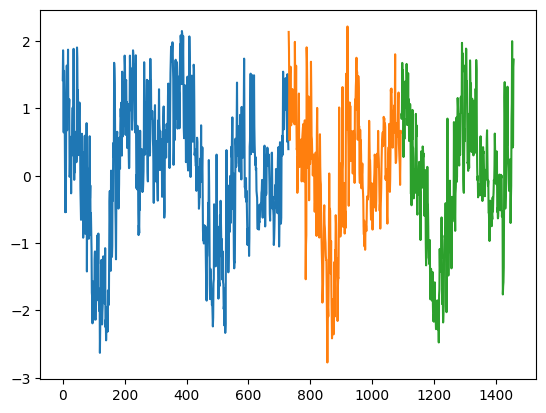

In [25]:
# %matplotlib qt
%matplotlib inline
plt.plot(np.array(list(range(trainData[:, 0, 1].shape[0]))), trainData[:, 0, 1])
plt.plot(np.array(list(range(trainData[:, 0, 1].shape[0],
                             trainData[:, 0, 1].shape[0] + valData[:, 0, 1].shape[0]))), valData[:, 0, 1])
plt.plot(np.array(list(range(trainData[:, 0, 1].shape[0] + valData[:, 0, 1].shape[0],
                             trainData[:, 0, 1].shape[0] + valData[:, 0, 1].shape[0] + testData[:, 0, 1].shape[0]))), testData[:, 0, 1])
plt.show()

Transformer NN implementation

In [26]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [27]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [28]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=30, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps.
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1).double()
    return mask  # (size, size)

create_look_ahead_mask(6)

class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):

        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)

        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [29]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [30]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim,
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.double()

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D

        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block

        x = self.output_projection(x)

        return x, attention_weights # (B,S,S)

In [31]:
# Test Forward pass on the Transformer:
transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                          inp_features=4, out_features=4, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(trainDataset))
print(inputs.shape)
print(targets.shape)

S = inputs.shape[1]
mask = create_look_ahead_mask(S)
out, attn = transformer (x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

torch.Size([32, 30, 4])
torch.Size([32, 30, 4])


(torch.Size([32, 30, 4]), torch.Size([32, 1, 30, 30]))

Training the Transformer

In [32]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 6756 parameters 


In [33]:
#########################################################
#TODO
# num_layers = number of the whole TransformerLayer
# D = attention heads dimension?
# H = number of attention heads
# hidden_mlp_dim = linear/FC layer dimension
# inp_features = input features (how many variables we input)
# out_features = output features (how many variables we want to predict)
# dropout_rate = dropout rate :D
transformer = Transformer(num_layers=4, D=32, H=4, hidden_mlp_dim=32,
                          inp_features=4, out_features=4, dropout_rate=0.1).to(device)

optimizer = torch.optim.RMSprop(transformer.parameters(),
                                lr=0.001)

# Here we just de-sequence the sequenced training data
trainTarget = [target[0, :] for target in trainData]
trainTarget = np.array(trainTarget)
trainTarget

array([[-2.07656586,  1.42058361, -1.53163384,  0.9616909 ],
       [-2.43103141,  1.86304324, -0.87049459,  1.24984769],
       [-2.46284242,  1.56807016, -0.50368803,  1.36691139],
       ...,
       [-1.92319134,  0.72002253, -1.22380474,  1.17555727],
       [-1.85502489,  0.60203329, -0.96589388,  0.82098934],
       [-1.75277521,  0.39555213, -0.91320241,  1.12490471]])

In [34]:
!pip3 install tqdm
from tqdm import tqdm

n_epochs = 100
niter = len(trainDataset)
losses, val_losses = [], []

for e in tqdm(range(n_epochs)):

    # one epoch on train set

    transformer.train()
    #sum_train_loss = 0.0

    # Here I get the first sequence from the training dataset - so first 30 days to predict from
    it = iter(trainDataset)
    (inputs, targets) = next(it)
    last_x = torch.unsqueeze(inputs[0], 0)  # unsqueeze because of the NN wants it this way, from [[1...5]..[1...5]] to [[[1...5]..[1...5]]]
    # Adding the first 30 days to the prediction list that will have the predictions
    train_predictions = list(last_x[0].detach().cpu().numpy())

    # While we do not have enough days predicted, we continue
    count = 0
    while len(train_predictions) < len(trainTarget):
        S = last_x.shape[1]
        mask = create_look_ahead_mask(S)
        # Predict
        p, attn = transformer(x=last_x, mask=mask)
        optimizer.step()
        # Add the new predicted values for one day to the prediction list
        train_predictions.append(p[0, -1, :].detach().cpu().numpy())
        # Roll to predict new day in next iteration
        last_x = torch.roll(last_x, -1, dims=1)
        new_values = p[0, -1, :]
        try:
          next_x = torch.unsqueeze(inputs[count], 0)
        except IndexError:
          (inputs, targets) = next(it)
          count = 0
          next_x = torch.unsqueeze(inputs[count], 0)
        # uncomment to include actual values of other variables
        # new_values[0] = next_x[:,-1,0]
        # new_values[2] = next_x[:,-1,2]
        # new_values[3] = next_x[:,-1,3]

        last_x[:,-1,:] = new_values
        count += 1

    #losses.append(sum_train_loss / (count+1))

100%|██████████| 100/100 [06:32<00:00,  3.92s/it]


In [35]:
#plt.plot(losses)
#plt.plot(val_losses)

In [36]:
# Here we just de-sequence the sequenced validation data
valTarget = [target[0, :] for target in valData]
valTarget = np.array(valTarget)
valTarget

array([[-1.41194295,  2.13589335, -0.86328418,  1.2599782 ],
       [-1.37785972,  1.86304324, -1.32641444,  1.19244145],
       [-1.51419263,  1.08136456,  0.57879807,  1.49635682],
       ...,
       [-1.20744359,  0.27018857,  0.11289458,  1.29374658],
       [-1.32673489,  0.66840224, -1.06573034,  1.20932564],
       [-1.39490134,  0.64627926, -1.06850358,  1.61454613]])

In [37]:
transformer.eval()

# Here I get the first sequence from the validation dataset - so first 30 days from val data to predict from
it = iter(valDataset)
(inputs, targets) = next(it)
last_x = torch.unsqueeze(inputs[0], 0)  # unsqueeze because of the NN wants it this way, from [[1...5]..[1...5]] to [[[1...5]..[1...5]]]
# Adding the first 30 days to the prediction list that will have the predictions
validation_predictions = list(last_x[0].detach().cpu().numpy())

# While we do not have enough days predicted, we continue
count = 0
while len(validation_predictions) < len(valTarget):
    S = last_x.shape[1]
    mask = create_look_ahead_mask(S)
    # Predict
    p, attn = transformer(x=last_x, mask=mask)
    # Add the new predicted values for one day to the prediction list
    validation_predictions.append(p[0, -1, :].detach().cpu().numpy())
    # Roll to predict new day in next iteration
    last_x = torch.roll(last_x, -1, dims=1)
    new_values = p[0, -1, :]
    try:
      next_x = torch.unsqueeze(inputs[count], 0)
    except IndexError:
      (inputs, targets) = next(it)
      count = 0
      next_x = torch.unsqueeze(inputs[count], 0)
    # uncomment to include actual values of other variables
    # new_values[0] = next_x[:,-1,0]
    # new_values[2] = next_x[:,-1,2]
    # new_values[3] = next_x[:,-1,3]
    last_x[:,-1,:] = new_values
    count += 1


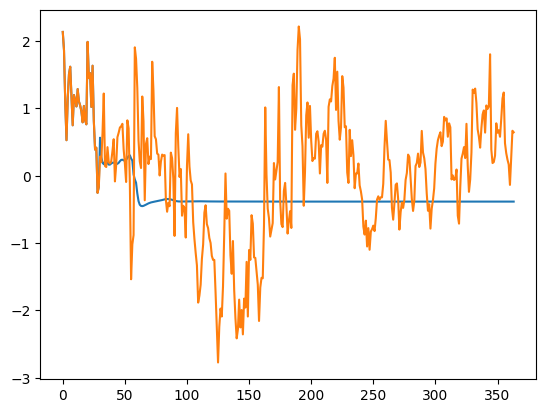

In [38]:


# %matplotlib qt
%matplotlib inline
plt.plot(np.array(validation_predictions)[:, 1])
plt.plot(valTarget[:, 1])
plt.show()

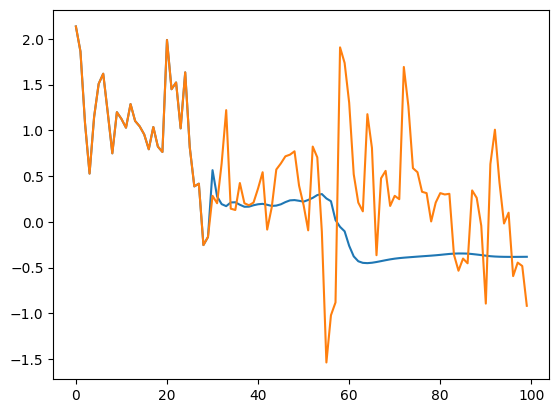

In [40]:
# %matplotlib qt
%matplotlib inline
plt.plot(np.array(validation_predictions)[:100, 1])
plt.plot(valTarget[:100, 1])
plt.show()